In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.layers import LSTM, Dense, Input, Embedding, Dropout
from tensorflow.keras.models import Model

In [2]:
# Loading the training data
train = pd.read_csv('/kaggle/input/spam-train-csv/train.csv')

In [3]:
train.head()

,qid,question_text,target
0,00002165364db923c7e6,How did Quebec nationalists see their province...,0
1,000032939017120e6e44,"Do you have an adopted dog, how would you enco...",0
2,0000412ca6e4628ce2cf,Why does velocity affect time? Does velocity a...,0
3,000042bf85aa498cd78e,How did Otto von Guericke used the Magdeburg h...,0
4,0000455dfa3e01eae3af,Can I convert montra helicon D to a mountain b...,0


In [4]:
# Reading word embeddings from a GloVe file and storing them in a dictionary
embedding_index = {}
f = open(r"/kaggle/input/glove-dataset/glove.6B.100d.txt", encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    wts = np.asarray(values[-100:], dtype='float32')
    embedding_index[word] = wts
f.close()

In [5]:
# Word vectors from GloVe file associated with 'today'
embedding_index['today']

array([-0.19939  ,  0.37846  ,  0.52093  ,  0.28347  , -0.1898   ,
       -0.20947  , -0.23286  ,  0.14185  , -0.034916 , -0.36006  ,
       -0.0046717, -0.25207  ,  0.31364  , -0.34879  ,  0.032268 ,
       -0.45078  ,  0.011292 ,  0.090903 , -0.62866  ,  0.0079579,
        0.28065  ,  0.34158  , -0.25593  ,  0.11521  ,  0.10571  ,
       -0.45827  ,  0.32193  , -0.29186  ,  0.11443  ,  0.17972  ,
       -0.31633  ,  0.40085  , -0.24405  , -0.050205 ,  0.16485  ,
        0.5001   ,  0.11756  ,  0.043875 , -0.060235 , -0.66571  ,
       -0.40628  , -0.21691  ,  0.068156 , -0.38058  , -0.4512   ,
       -0.26966  ,  0.45961  , -0.23446  , -0.26416  , -1.1617   ,
        0.18417  , -0.53088  ,  0.54179  ,  0.78295  , -0.54864  ,
       -2.0634   , -0.63427  ,  0.095073 ,  1.9649   ,  0.47031  ,
       -0.54401  ,  0.73015  , -0.34352  , -0.43033  ,  0.27555  ,
        0.025185 ,  0.35053  ,  0.46295  ,  0.40837  , -0.011836 ,
        0.34553  , -0.17297  , -0.13765  , -0.23182  ,  0.3898

In [6]:
from sklearn.model_selection import train_test_split
Train_train, Test_test=train_test_split(train, test_size=0.2)

In [7]:
x_train=Train_train['question_text']
y_train=Train_train['target']
x_test=Test_test['question_text']
y_test=Test_test['target']

In [8]:
# New column to dataframe 'train' with name:'length'
train['length']=[len(x) for x in train['question_text']]

In [9]:
# To get the maximum and minimum values in the 'length' column of the DataFrame train
train['length'].max(),train['length'].min()

(1017, 1)

In [10]:
max_len=251
# To create a Tokenizer object named 'Tk' for tokenizing text data.
Tk=Tokenizer(char_level=False,split=' ')
# Tokenizer learns the vocabulary and tokenizes the text in x_train
Tk.fit_on_texts(x_train)

In [11]:
# To calculate the number of unique words (or tokens) in your text data, which is the vocabulary size of the tokenizer('Tk')
vocab_size=len(Tk.word_index)

In [12]:
vocab_size

196127

In [13]:
# To convert the text sequences in your training dataset x_train into sequences of integers
seq_train=Tk.texts_to_sequences(x_train)
# To convert the text sequences in your test dataset x_test into a matrix format.
seq_test=Tk.texts_to_matrix(x_test)

In [14]:
# Padding the x_train and x_test files to the max. length taken
seq_train_matrix=sequence.pad_sequences(seq_train,maxlen=max_len)
seq_test_matrix=sequence.pad_sequences(seq_test,maxlen=max_len)

In [15]:
# To initialize the embedding layer in a deep learning model with pre-trained word embeddings.
embedding_matrix=np.zeros((vocab_size+1,100))

In [16]:
# To fill the embedding_matrix with pre-trained word vectors obtained from the embedding_index dictionary
for word,i in Tk.word_index.items():
  # To retrieve the pre-trained word vector for the current word word from the embedding_index dictionary.
  embed_vector=embedding_index.get(word)

  if embed_vector is not None:
    embedding_matrix[i]=embed_vector

In [17]:
# Define input and embedding layers
inputs = Input(name='question_text', shape=[max_len])
embed = Embedding(vocab_size + 1, 100, input_length=max_len, mask_zero=True, weights=[embedding_matrix], trainable=False)(inputs)

# Define the LSTM layer with unroll=True to disable cuDNN
lstm_layer = LSTM(50, recurrent_activation='sigmoid', unroll=True)(embed)

# Define remaining layers
dense1 = Dense(10, activation='relu')(lstm_layer)
dr1 = Dropout(0.2)(dense1)
final_layer = Dense(1, activation='sigmoid')(dr1)

# Build and compile the model
model = Model(inputs=inputs, outputs=final_layer)
model.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ question_text       │ (None, 251)       │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 251, 100)  │ 19,612,800 │ question_text[0]… │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 251)       │          0 │ question_text[0]… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lstm (LSTM)         │ (None, 50)        │     30,200 │ embedding[0][0],  │
│                     │                   │            │ not_equal[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 10)        │        510 │ lstm[0][0]        │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 10)        │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │         11 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 19,643,521 (74.93 MB)

 Trainable params: 30,721 (120.00 KB)

 Non-trainable params: 19,612,800 (74.82 MB)

In [20]:
# Compiling and training the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(seq_train_matrix, y_train, validation_data=[seq_test_matrix, y_test], epochs=20, batch_size=50)

Epoch 1/20
20898/20898 ━━━━━━━━━━━━━━━━━━━━ 588s 22ms/step - accuracy: 0.9621 - loss: 0.0931 - val_accuracy: 0.9390 - val_loss: 0.3870
Epoch 2/20
20898/20898 ━━━━━━━━━━━━━━━━━━━━ 314s 15ms/step - accuracy: 0.9620 - loss: 0.0925 - val_accuracy: 0.9390 - val_loss: 0.4129
Epoch 3/20
20898/20898 ━━━━━━━━━━━━━━━━━━━━ 317s 15ms/step - accuracy: 0.9628 - loss: 0.0911 - val_accuracy: 0.9390 - val_loss: 0.4198
Epoch 4/20
20898/20898 ━━━━━━━━━━━━━━━━━━━━ 315s 15ms/step - accuracy: 0.9628 - loss: 0.0907 - val_accuracy: 0.9390 - val_loss: 0.4398
Epoch 5/20
20898/20898 ━━━━━━━━━━━━━━━━━━━━ 315s 15ms/step - accuracy: 0.9633 - loss: 0.0900 - val_accuracy: 0.9390 - val_loss: 0.4204
Epoch 6/20
20898/20898 ━━━━━━━━━━━━━━━━━━━━ 315s 15ms/step - accuracy: 0.9638 - loss: 0.0886 - val_accuracy: 0.9390 - val_loss: 0.4539
Epoch 7/20
20898/20898 ━━━━━━━━━━━━━━━━━━━━ 316s 15ms/step - accuracy: 0.9637 - loss: 0.0880 - val_accuracy: 0.9390 - val_loss: 0.4615
Epoch 8/20
20898/20898 ━━━━━━━━━━━━━━━━━━━━ 316s 15ms/s

8164/8164 ━━━━━━━━━━━━━━━━━━━━ 35s 4ms/step


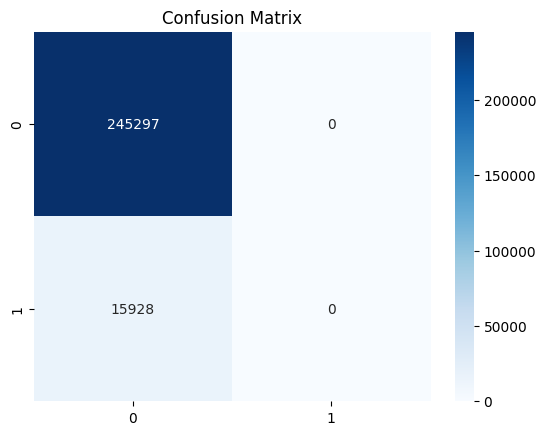

Classification Report:


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


              precision    recall  f1-score   support

           0       0.94      1.00      0.97    245297
           1       0.00      0.00      0.00     15928

    accuracy                           0.94    261225
   macro avg       0.47      0.50      0.48    261225
weighted avg       0.88      0.94      0.91    261225

ROC-AUC Score: 0.4999


/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [23]:
# Predict the probabilities for the test set
y_pred_proba = model.predict(seq_test_matrix)

# Convert probabilities to binary output
y_pred = (y_pred_proba > 0.5).astype(int)

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# Classification Report
print("Classification Report:")
print(classification_report(y_test, y_pred))

# ROC-AUC Score
roc_auc = roc_auc_score(y_test, y_pred_proba)
print(f"ROC-AUC Score: {roc_auc:.4f}")